In [2]:
# Importing initial packages
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, Dataset
import seaborn as sns
import matplotlib.pyplot as plt

# Setting the device to GPU for parallelization
device = 'mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

mps


In [3]:
# Setting Hyperparameters
batch_size = 64
epochs = 100

## Data Loading, Cleaning, and Preprocessing

### Data Loading

In [4]:
# In my project folder I added a data folder with both files (found in repo README) but did not push (gitignore) due to size
movies = pd.read_csv('data/movies.csv')

ratings = pd.read_csv('data/ratings.csv')

#### Inspecting the data

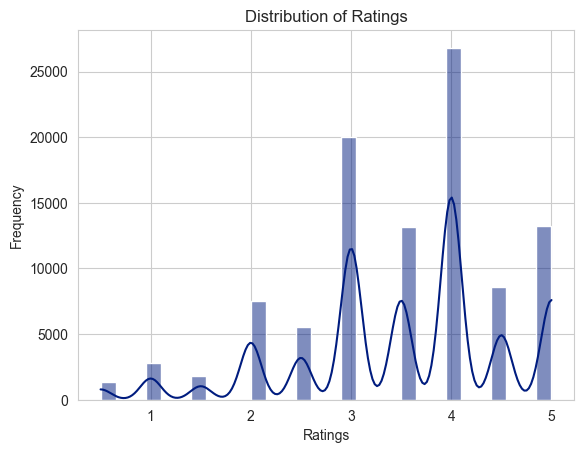

In [5]:
sns.set_style("whitegrid")
sns.set_palette("dark")
sns.histplot(ratings['rating'], bins=30, kde=True)
plt.xlabel('Ratings')
plt.ylabel('Frequency')
plt.title('Distribution of Ratings')
plt.show()

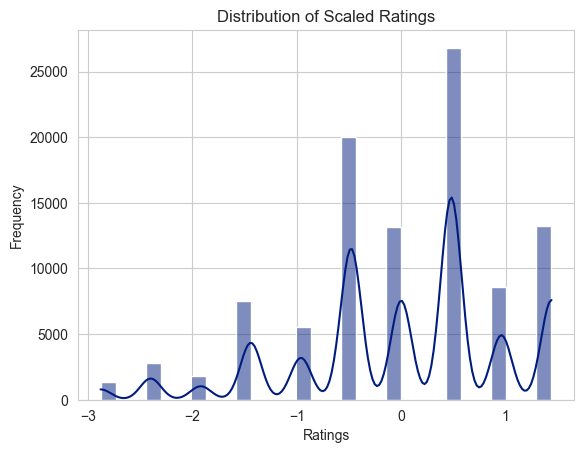

In [6]:
scaler = StandardScaler()
ratings['rating_scaled'] = scaler.fit_transform(ratings[['rating']])

sns.histplot(ratings['rating_scaled'], bins=30, kde=True)
plt.xlabel('Ratings')
plt.ylabel('Frequency')
plt.title('Distribution of Scaled Ratings')
plt.show()

In [7]:
print(f"""The shape of movies is: {movies.shape}
The shape of rating is: {ratings.shape}""")

print(f"""The columns of movies is: {movies.columns.to_list()}
The columns of rating is: {ratings.columns.to_list()}

* Notice that both df's have a movieId column, which will be useful for merging""")

The shape of movies is: (9742, 3)
The shape of rating is: (100836, 5)
The columns of movies is: ['movieId', 'title', 'genres']
The columns of rating is: ['userId', 'movieId', 'rating', 'timestamp', 'rating_scaled']

* Notice that both df's have a movieId column, which will be useful for merging


In [8]:
# Creating encoders and decoders for our movie ids
movie_ids = list(movies.movieId)
moviesid_to_title = dict(zip(movies.movieId,movies.title))    # Decoder
movietitle_to_id = {j:i for i,j in moviesid_to_title.items()} # Encoder

movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [9]:
ratings.head()

,userId,movieId,rating,timestamp,rating_scaled
0,1,1,4.0,964982703,0.478112
1,1,3,4.0,964981247,0.478112
2,1,6,4.0,964982224,0.478112
3,1,47,5.0,964983815,1.437322
4,1,50,5.0,964982931,1.437322


As this is an already cleaned dataset, we can skip over to data preprocessing.

### Data Preprocessing

For this project we will first need to create a user-movie interaction matrix.

In [10]:
# Assume NAs are not watched by user, so rating of 0
user_rating_matrix = ratings.pivot(index='userId', columns='movieId', values='rating_scaled').fillna(0)
user_rating_matrix.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,0.478112,0.0,0.478112,0.0,0.0,0.478112,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.478112,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
# Convert this from a pandas df to numpy array
user_rating_matrix_np = user_rating_matrix.values
print(f"Shape of the numpy matrix: {user_rating_matrix_np.shape}; represting {user_rating_matrix_np.shape[0]} users with {user_rating_matrix_np.shape[1]} movies.")

Shape of the numpy matrix: (610, 9724); represting 610 users with 9724 movies.


In [12]:
# Split into training and test split
train_data, test_data = train_test_split(user_rating_matrix_np, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
train_data = torch.FloatTensor(train_data)
test_data = torch.FloatTensor(test_data)

### Creating DataLoader

In [13]:
class RatingsDataset(Dataset):
    def __init__(self, data):
        self.data = data.nonzero(as_tuple=True) # Get the indices of non-zero elements
        self.ratings = data[self.data] # Using non-zero indiced to extract those ratings

    def __len__ (self):
        return len(self.data[0])
    
    def __getitem__ (self, idx):
        user = self.data[0][idx]
        item = self.data[1][idx]
        rating = self.ratings[idx]
        
        return user, item, rating
    
train_dataset = RatingsDataset(train_data)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle = True)

test_dataset = RatingsDataset(test_data)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle = False)

print(f"Batch size: {batch_size}")
print(f"Number of samples in train_dataset: {len(train_dataset)}")
print(f"Number of samples in test_dataset: {len(test_dataset)}")


Batch size: 64
Number of samples in train_dataset: 73177
Number of samples in test_dataset: 27659


## Model Development

### Defining Recommender model class

In [14]:
# Model definition
class Recommender(nn.Module):
    def __init__(self, num_users, num_items, n_embd = 64):
        super(Recommender, self).__init__()
        self.user_embedding = nn.Embedding(num_users, n_embd) # Creating an embedding for our users with the correct dimensions
        self.item_embedding = nn.Embedding(num_items, n_embd) # Embedding items
        self.fc1 = nn.Linear(n_embd * 2, 128)                 # First fully connected (fc) layer
        self.fc2 = nn.Linear(128, 64)                         # Second fc layer
        self.fc3 = nn.Linear(64, 1)                           # Finaly fc layer, with an output of one value
        self.sigmoid = nn.Sigmoid()                         # Sigmoid activation function to compress the output to a value between (0,1)

    def forward(self, user, item):
        user_embed = self.user_embedding(user)          # Embedding our users
        item_embed = self.item_embedding(item)          # Embedding the movies
        x = torch.cat([user_embed, item_embed], dim=-1) # Concatenating the users and items 
        x = torch.relu(self.fc1(x))                     # Applying first fc layer, with a ReLU activation function
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)                                 # Final layer to get predicted rating
        x = self.sigmoid(x)                           # Applying the sigmoid function
        x = x*5                          # Scale the output to [0,5]   
        return x

# Defining model parameters (amount of users and movies) based on our data
num_users, num_items = user_rating_matrix_np.shape
# Initializing the model
model = Recommender(num_users, num_items).to(device)

### Defining Loss Function and Optimizer
Purpose:

In [15]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)

Now that we have created our model, and prepared the data for training, we can move onto model training!

## Model Training

In [49]:
def training_loop(epochs):
    model.train()
    loss_dict = {}
    for epoch in range(epochs):
        total_loss = 0
        for user, item, rating in train_loader:
            user, item, rating = user.to(device), item.to(device), rating.to(device)
            optimizer.zero_grad()
            output = model(user, item).squeeze()
            loss = criterion(output, rating)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        # Print loss after every ten epochs
        if (epoch+1)%10==0:
            epoch_loss = total_loss/len(train_loader) # Get the average loss for this epoch
            loss_dict[epoch] = epoch_loss # Store this epoch, loss into a dict for graphing
            print(f"Epoch {epoch+1}, Loss: {epoch_loss}")  # Print the average loss for this epoch
    
    return loss_dict

training_loop(epochs)

KeyboardInterrupt: 

## Model Evaluation

In [18]:
model.eval()
total_loss = 0
with torch.no_grad():
    for user, item, rating in test_loader:
        user, item, rating = user.to(device), item.to(device), rating.to(device)
        output = model(user, item).squeeze()
        loss = criterion(output, rating)
        total_loss += loss.item()
    
test_loss = total_loss / len(test_loader)   

print(f"Test Loss: {test_loss}")

Test Loss: 1.0867008083687093


We recieved a test loss much higher than our training loss. We overfit! We'll continue to tuning the model

In [19]:
import seaborn as sns

## Hyperparameter Tuning

In [ ]:
learning_rates = [0.001, 0.003, 0.01]


for lr in learning_rates:
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr = lr)

    

## Using the Model

In [20]:
def recommend_movies(user_id, movie_ids, top_n=10):
    model.eval()  # Set model to evaluation mode
    device = next(model.parameters()).device  # Get the device of the model parameters
    user = torch.tensor([user_id] * len(movie_ids)).to(device)  # Ensure tensor is on the same device as the model
    movies = torch.tensor(movie_ids).to(device)  # Ensure tensor is on the same device as the model
    with torch.no_grad():
        predicted_ratings = model(user, movies).squeeze()
    top_movie_indices = predicted_ratings.argsort(descending=True)[:top_n]
    recommended_movie_ids = movies[top_movie_indices].tolist()
    recommended_ratings = predicted_ratings[top_movie_indices].tolist()
    recommendations = list(zip(recommended_movie_ids, recommended_ratings))
    return recommendations

# Example usage for recommendations
recommended_movies = recommend_movies(0, movie_ids, top_n=1)

ratings_list = []
for id in ratings.userId.unique():
        recommended_movies = recommend_movies(id, movie_ids, top_n=1)
        ratings_list.append(recommended_movies[0][1])



#print(f"Movie ID: {moviesid_to_title[movie_id]}, Estimated Rating: {rating:.2f}")



<Axes: >

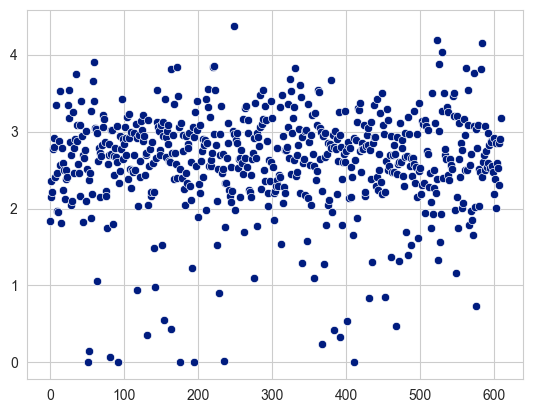

In [21]:
sns.scatterplot(ratings_list)

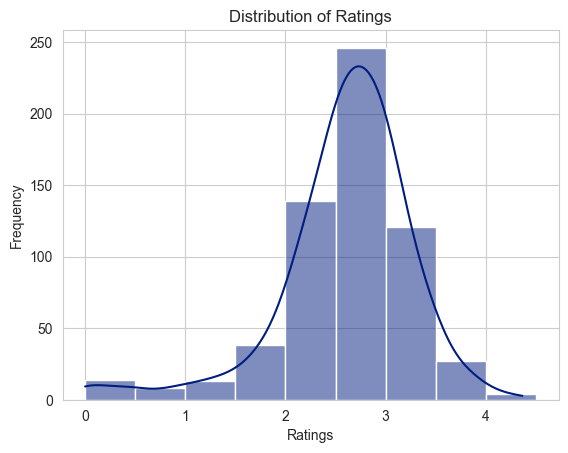

In [40]:
sns.histplot(ratings_list, bins=np.arange(0,5,0.5), kde=True)
plt.xlabel('Ratings')
plt.ylabel('Frequency')
plt.title('Distribution of Ratings')
plt.show()

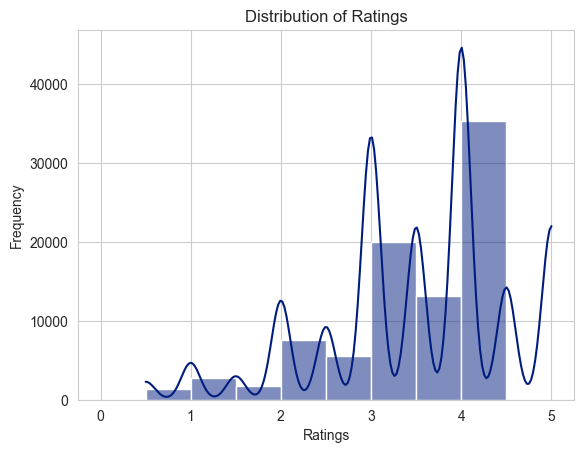

In [39]:
sns.histplot(ratings['rating'], bins=np.arange(0,5,0.5), kde=True)
plt.xlabel('Ratings')
plt.ylabel('Frequency')
plt.title('Distribution of Ratings')
plt.show()

In [46]:
ratings['rating'].describe()

count    100836.000000
mean          3.501557
std           1.042529
min           0.500000
25%           3.000000
50%           3.500000
75%           4.000000
max           5.000000
Name: rating, dtype: float64

In [48]:
ratings_series = pd.Series(ratings_list)
ratings_series.describe()

count    610.000000
mean       2.603722
std        0.667314
min        0.000171
25%        2.334536
50%        2.688866
75%        2.996487
max        4.364077
dtype: float64